In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('axes', titlesize=20)

## 2a Performing a Calibration for Simulated VNA with Parasitics

In simulation, I've done a OSL Calibration:

* Open: 0.005 Ohms
* Short: 1 TOhms
* Load: 50 Ohms

By doing an AC analysis between 1 MHz and 10 GHz, for each analysis, I computed the reflection coefficient $\Gamma$ using the traveling wave definitions:$$V_{+} = 0.5 \cdot (V_p + Z_0 \cdot I_p)$$$$V_{-} = 0.5 \cdot (V_p - Z_0 \cdot I_p)$$$$\Gamma = \frac{V_{-}}{V_{+}}$$


In [4]:
def load_spice_data(filename):
    # ngspice wrdata format: [freq, real, imag]
    data = np.loadtxt(filename)
    return data[:, 1] + 1j * data[:, 2]
def load_freq(filename):
    data = np.loadtxt(filename)
    return data[:,0]

Text(0.5, 0, 'Hz')

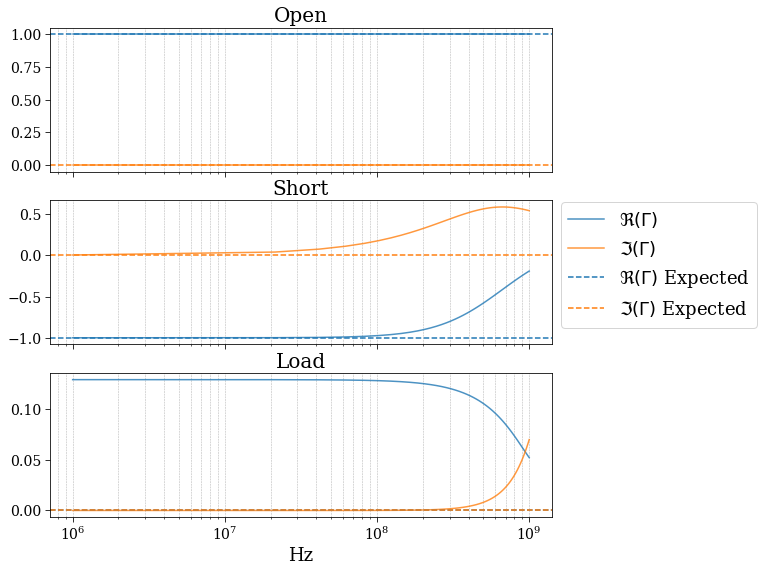

In [52]:
g_s = load_spice_data('parasitics_data/cal_short.txt')
g_o = load_spice_data('parasitics_data/cal_open.txt')
g_l = load_spice_data('parasitics_data/cal_load.txt')
g_dut = load_spice_data('parasitics_data/dut_raw.txt')

freqs = load_freq('parasitics_data/cal_load.txt')
#ideal gamma
ig_s = -1.0 + 0j
ig_o = 1.0 + 0j
ig_l = 0.0 + 0j

fig,axs=plt.subplots(3,1,figsize=(9,9))

axs[1].set_title('Short')
axs[1].plot(freqs,g_s.real, alpha=0.8)
axs[1].plot(freqs,g_s.imag, alpha=0.8)
axs[1].axhline(ig_s.real, color='tab:blue', linestyle='dashed')
axs[1].axhline(ig_s.imag, color='tab:orange', linestyle='dashed')
axs[1].set_xscale('log')
#axs[0].set_xlabel('Hz', loc='left', fontsize=12)
axs[1].grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)
axs[1].set_xticklabels([])
#axs[0].get_xaxis().set_visible(False)

axs[0].set_title('Open')
axs[0].plot(freqs,g_o.real, alpha=0.8)
axs[0].plot(freqs,g_o.imag, alpha=0.8)
axs[0].axhline(ig_o.real, color='tab:blue', linestyle='dashed')
axs[0].axhline(ig_o.imag, color='tab:orange', linestyle='dashed')
axs[0].set_xscale('log')

axs[0].grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)
axs[0].set_xticklabels([])

axs[2].set_title('Load')
axs[2].plot(freqs,g_l.real, alpha=0.8, label='$\Re(\Gamma)$')
axs[2].plot(freqs,g_l.imag, alpha=0.8, label='$\Im(\Gamma)$')
axs[2].axhline(ig_l.real, color='tab:blue', linestyle='dashed', label='$\Re(\Gamma)$ Expected')
axs[2].axhline(ig_l.imag, color='tab:orange', linestyle='dashed', label='$\Im(\Gamma)$ Expected')
axs[2].set_xscale('log')
axs[2].legend(loc='center left', bbox_to_anchor=(1, 1.75), fontsize=18)
axs[2].grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)

axs[2].set_xlabel('Hz')

These results show the Real and Imaginary parts of $\Gamma$ as a function of injected frequency. They reveal how the parasitics model warps our expected response at various frequencies. we use these measurements to correct for the actual values

Now onto the calibration... The measured $\Gamma$ is expressed as:

$\begin{gather}
    \Gamma_m = E_{d} + \frac{E_r \times \Gamma_i}{1-E_{s}\times \Gamma_i}
\end{gather}
$

where:
* $E_d$ is known as the directivity error
* $E_r$ is known as the reflection error
* $E_s$ is known as the source match error

We can work this out for each of the calibration cases:

$\begin{align}
\text{Load, DUT = 50 $\Omega$, $\Gamma_i$ = 0} \quad\quad \Gamma_l &= E_d\\
\text{Short, DUT = 0 $\Omega$, $\Gamma_i$ = -1} \quad \quad \Gamma_s &= E_d - \frac{E_r}{1+E_s}\\
\text{Open, DUT = 1 T $\Omega$, $\Gamma_i$ = 1} \quad \quad \Gamma_o &= E_d + \frac{E_r}{1-E_s}
\end{align}$

Then, the matched load measurement simply gives us the directivity error. We solve for $E_s$ and $E_r$ by rewriting $\Gamma_s$ and $\Gamma_o$ and inserting $\Gamma_l$:

$\begin{align}
(\Gamma_s - \Gamma_l)(1+E_s)=-E_r \quad \rightarrow \quad \Gamma_s=\Gamma_l +E_s\Gamma_l - E_s\Gamma_s - E_r\\
(\Gamma_o-\Gamma_l)(1-E_s)=E_r \quad \rightarrow \quad \Gamma_o = \Gamma_l -E_s \Gamma_l + E_s\Gamma_o + E_r
\end{align}$

Adding the two gives us:

$\begin{align}
E_s = \frac{\Gamma_s + \Gamma_o - 2\Gamma_l}{\Gamma_o-\Gamma_s}
\end{align}$

which we can substitute back in to get:

$\begin{align}
E_r = (\Gamma_l-\Gamma_s)(1+E_s)
\end{align}$

and we can write the corrected $\Gamma$ as:

$\begin{align}
\Gamma= \frac{\Gamma_m -E_d}{E_r + E_s(\Gamma_m - E_d)}
\end{align}$

In [17]:

# Directivity (edf) is g_l if ig_l is exactly 0
e_df = g_l

# Source Match (esf)
e_sf = (g_s+g_o-2*g_l) / (g_o-g_s)

# Reflection Tracking (erf)
e_rf = (g_l-g_s)*(1+e_sf)



# Apply Correction to DUT measurement
gamma_corrected = (g_dut - e_df) / (e_rf + e_sf * (g_dut - e_df))


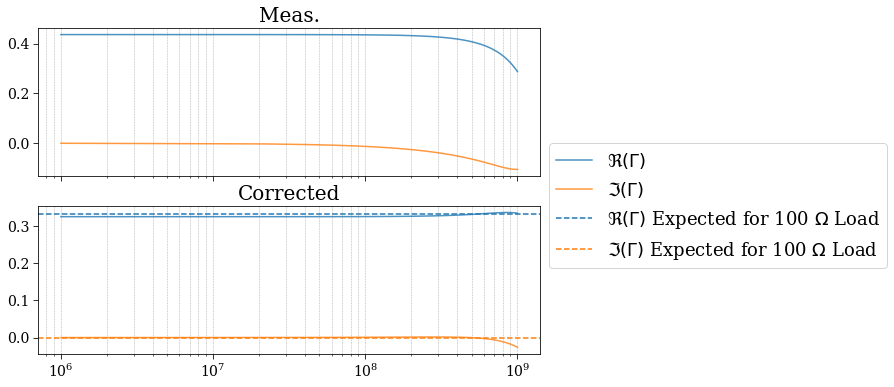

In [51]:
fig,axs=plt.subplots(2,1,figsize=(9,6))


axs[0].set_title('Meas.')
axs[0].plot(freqs,g_dut.real, alpha=0.8)
axs[0].plot(freqs,g_dut.imag, alpha=0.8)
#axs[0].axhline(ig_s.real, color='tab:blue', linestyle='dashed')
#axs[0].axhline(ig_s.imag, color='tab:orange', linestyle='dashed')
axs[0].set_xscale('log')
axs[0].grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)
axs[0].set_xticklabels([])

axs[1].set_title('Corrected')
axs[1].plot(freqs,gamma_corrected.real, alpha=0.8, label='$\Re(\Gamma)$')
axs[1].plot(freqs,gamma_corrected.imag, alpha=0.8, label='$\Im(\Gamma)$')
axs[1].axhline(0.333, color='tab:blue', linestyle='dashed', label='$\Re(\Gamma)$ Expected for 100 $\Omega$ Load')
axs[1].axhline(0, color='tab:orange', linestyle='dashed', label='$\Im(\Gamma)$ Expected for 100 $\Omega$ Load')
axs[1].set_xscale('log')
axs[1].grid(True, which="both", axis='x', linestyle='--', linewidth=0.5)
#axs[0].set_xticklabels([])
axs[1].legend(loc='center left', bbox_to_anchor=(1, 1), fontsize=18)



which shows the effects of our correction, at least up to a frequency ~1 GHz. This is fine for now, but I should come back and play around with the cause of this.


## 2b: Simulating a Directional Coupler